In [3]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 788.1 kB/s eta 0:00:00


In [4]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [5]:
g = 3.71  # Ускорение свободного падения на Марсе
M = 700   # Расстояние до обрыва
m = 200    # Расстояние до стены
h = 400    # Высота стены

LIGHT_PENALTY_PARAM = 10
HARD_PENALTY_PARAM = 80

def evaluate(individual):
    v0, theta = individual

    if v0 < 0:
      v0 = -v0
    if theta < 0:
      theta = -theta
    if theta > np.pi/2:
      theta = np.pi - theta

    # Расчет дальности полета
    L = (v0 ** 2) * np.sin(2 * theta) / g
    dist_to_target = M - L
    light_penalty = abs(dist_to_target) * LIGHT_PENALTY_PARAM if dist_to_target < 0 else 0

    # Проверка пересечения стены
    height = m * np.tan(theta) - (1 / 2) * g * ((m / (v0 * np.cos(theta))) ** 2)
    hard_penalty = (h-height) * HARD_PENALTY_PARAM if height < h else 0

    return abs(dist_to_target) + light_penalty + hard_penalty,


In [6]:
def angle_generating():
    return random.uniform(0, np.pi / 2)

def speed_generating():
    return random.uniform(0, 100)

In [7]:
POPULATION = 100
HALL_OF_FAME = 5
P_CROSS = 0.9 # вероятность скрещивания
P_MUTATION = 0.2 # вероятность мутации
MAX_GENERATIONS = 100

def genetic_algorythm():
  # Определение типа фитнеса и хромосомы
  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMin)

  # Инициализация объектов для работы с хромосомами
  toolbox = base.Toolbox()

  # Определение функций для генерации и оценки индивидов
  toolbox.register("angle", angle_generating)
  toolbox.register("speed", speed_generating)
  toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.speed, toolbox.angle))
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Регистрация операций ГА
  toolbox.register("evaluate", evaluate)
  # toolbox.register("mate", tools.cxTwoPoint)
  toolbox.register("mate", tools.cxBlend, alpha=0.5)
  toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=[5, 0.1], indpb=0.2)
  toolbox.register("select", tools.selTournament, tournsize=3)

  pop = toolbox.population(n=POPULATION)
  hof = tools.HallOfFame(HALL_OF_FAME)
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)
  pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=P_CROSS, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

  best = hof[0]
  v0, theta = best
  print(f"Best solution: speed = {v0}, angle = {theta}")

  # Расчет дальности полета
  L = (v0 ** 2) * np.sin(2 * theta) / g
  dist_to_target = M - L
  light_penalty = abs(dist_to_target) * LIGHT_PENALTY_PARAM if dist_to_target < 0 else 0

  # Проверка пересечения стены
  height = m * np.tan(theta) - (1 / 2) * g * ((m / (v0 * np.cos(theta))) ** 2)
  hard_penalty = (h-height) * HARD_PENALTY_PARAM if height < h else 0

  print("Metric result: ", abs(dist_to_target))
  print("Light penalty: ", light_penalty)
  print("Hard penalty: ", hard_penalty)

  minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
  sns.set_style("whitegrid")

  plt.plot(minFitnessValues, color='red')
  plt.xlabel('Generation')
  plt.ylabel('Min')
  plt.show()

  plt.plot(meanFitnessValues, color='blue')
  plt.xlabel('Generation')
  plt.ylabel('Average Fitness')
  plt.show()

  return v0, theta

gen	nevals	avg        	std        	min   	max        
0  	100   	2.14593e+07	1.51971e+08	177.85	1.38349e+09
1  	90    	2.20255e+06	2.1429e+07 	5.87603	2.15413e+08
2  	93    	55452.3    	333631     	1.68879	3.29372e+06
3  	89    	24981.5    	102247     	1.68879	899200     
4  	93    	17634      	105742     	1.68879	1.00814e+06
5  	93    	19451      	92245      	7.76802	780616     
6  	78    	548.96     	1531.87    	1.15031	11177.2    
7  	90    	345.708    	802.031    	1.4224 	5544.73    
8  	84    	2.74708e+06	2.7331e+07 	4.15754	2.74687e+08
9  	86    	374.213    	1250.82    	1.15227	10901.6    
10 	91    	200.652    	459.486    	2.83788	2982.79    
11 	92    	2171.6     	20005.6    	1.0032 	201200     
12 	94    	175.294    	336.776    	1.22848	2249.51    
13 	91    	112.428    	252.1      	1.22848	1578.47    
14 	94    	2003.35    	17660.5    	1.2952 	177662     
15 	91    	168.677    	450.406    	0.092113	3161.37    
16 	86    	151.704    	587.69     	0.083042	5232.64    
17 	89    

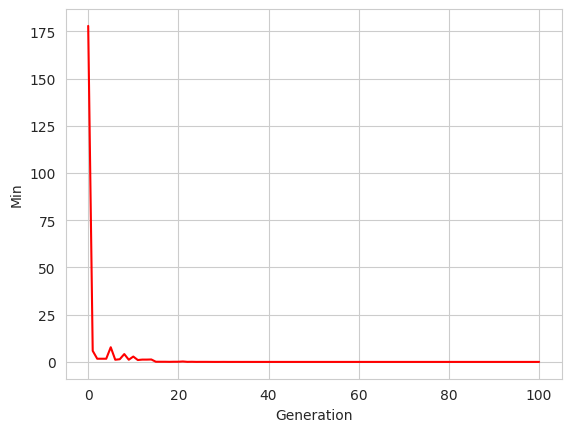

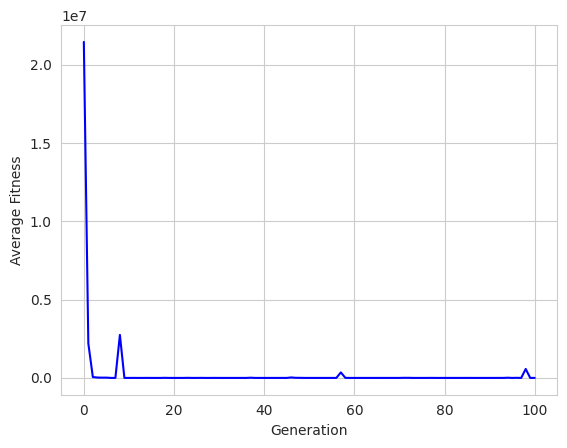

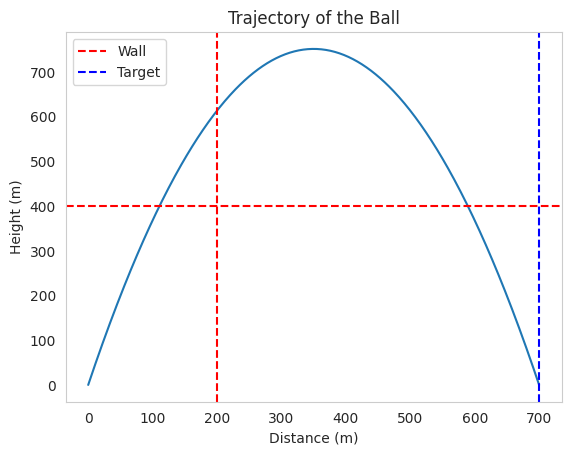

In [8]:
v0, theta = genetic_algorythm()
# Визуализация траектории
import matplotlib.pyplot as plt

t = np.linspace(0, 2 * v0 * np.sin(theta) / g, num=500)
x = v0 * t * np.cos(theta)
y = v0 * t * np.sin(theta) - 0.5 * g * t**2

plt.plot(x, y)
plt.axvline(m, color='red', linestyle='--', label='Wall')
plt.axhline(h, color='red', linestyle='--')
plt.axvline(M, color='blue', linestyle='--', label='Target')
plt.title("Trajectory of the Ball")
plt.xlabel("Distance (m)")
plt.ylabel("Height (m)")
plt.legend()
plt.grid()
plt.show()